在前面几关的学习中，总共学习了逻辑回归、`KMeans`、决策树、`SVM` 支持向量机和 `XGBoost`，我相信通过前面实际数据的模型实践和闯关题的解答，大家都已经学会了如何训练模型，那么我们就开始这个训练营的最后一关 **堪培拉天气数据预测实战**。  

下面我会给大家列出具体的实施步骤，**需要大家补充完代码然后提交文件**！大家可以参考之前的关卡完成实战项目。  

开始之前我先介绍下实战的数据集：  
 - `train_weather.csv` 训练数据集。  
 - `test_weather.csv` 提交测试数据集。  
 - `submit_result.csv` 提交结果数据集。

数据集中的特征含义表示如下：  

| 特征列名称 | 特征含义 |  
| ------- | ----------- |  
| Date           |  日期 |  
| Location       | 观察的城市  |  
| MinTemp        |  当天最低温度（摄氏度） |  
| MaxTemp        | 当天最高温度（摄氏度）温度都是 string  |  
| Rainfall       | 当天的降雨量（单位是毫米mm）  |  
| Evaporation    | 一个凹地上面水的蒸发量（单位是毫米mm），24小时内到早上9点  |  
| Sunshine       | 一天中出太阳的小时数  |  
| WindGustDir    |  最强劲的那股风的风向，24小时内到午夜 |  
| WindGustSpeed  |  最强劲的那股风的风速（km/h），24小时内到午夜 |  
| WindDir9am     | 上午9点的风向  |  
| WindDir3pm     | 下午3点的风向  |  
| WindSpeed9am   |  上午9点之前的十分钟里的平均风速，即 8:50~9:00的平均风速，单位是（km/hr） |  
| WindSpeed3pm   |  下午3点之前的十分钟里的平均风速，即 14:50~15:00的平均风速，单位是（km/hr） |  
| Humidity9am    | 上午9点的湿度  |  
| Humidity3pm    |  下午3点的湿度 |  
| Pressure9am    |  上午9点的大气压强（hpa） |  
| Pressure3pm    |  下午3点的大气压强 |  
| Cloud9am       | 上午9点天空中云的密度，取值是[0, 8]，以1位一个单位，0的话表示天空中几乎没云，8的话表示天空中几乎被云覆盖了  |  
| Cloud3pm       | 下午3点天空中云的密度  |  
| Temp9am        |  上午9点的温度（单位是摄氏度） |  
| Temp3pm        | 下午3点的温度（单位是摄氏度） |  
| RainTomorrow   |  明天是否下雨标签 | 

### 引入依赖

In [44]:
# 引入依赖

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 加载数据

In [45]:
# 加载数据

train = pd.read_csv('train_weather.csv', index_col='Unnamed: 0')
test = pd.read_csv('test_weather.csv', index_col='Unnamed: 0')
submit = pd.read_csv('submit_result.csv', index_col='Unnamed: 0')
train.head(), test.head()

# 提交结果数据集


(         Date     Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
 0  2009-10-14    NorahHead     15.1     23.9       0.0          NaN       NaN   
 1  2011-09-26      Walpole      9.7     14.2       7.6          NaN       NaN   
 2  2010-04-20  Williamtown     13.2     25.4       0.0          3.2       8.8   
 3  2011-07-12       Hobart      7.6     14.8       0.0          4.0       7.0   
 4  2015-04-13  Williamtown     12.9     22.2       0.0          4.0       7.9   
 
   WindGustDir  WindGustSpeed WindDir9am  ... WindSpeed3pm  Humidity9am  \
 0         SSW           67.0         NW  ...         22.0         38.0   
 1         WSW           50.0        WNW  ...         28.0         91.0   
 2         ENE           30.0          W  ...         17.0         79.0   
 3         WNW           94.0        WNW  ...         35.0         52.0   
 4           S           37.0         SW  ...         20.0         69.0   
 
    Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  C

### 数据基础性分析

In [46]:
# 数据基础性分析

# 查看训练集和结果集数据空值、类型
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113754 entries, 0 to 113753
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           113754 non-null  object 
 1   Location       113754 non-null  object 
 2   MinTemp        113229 non-null  float64
 3   MaxTemp        113486 non-null  float64
 4   Rainfall       112572 non-null  float64
 5   Evaporation    64963 non-null   float64
 6   Sunshine       59409 non-null   float64
 7   WindGustDir    106296 non-null  object 
 8   WindGustSpeed  106348 non-null  float64
 9   WindDir9am     105718 non-null  object 
 10  WindDir3pm     110731 non-null  object 
 11  WindSpeed9am   112671 non-null  float64
 12  WindSpeed3pm   111645 non-null  float64
 13  Humidity9am    112334 non-null  float64
 14  Humidity3pm    110841 non-null  float64
 15  Pressure9am    102497 non-null  float64
 16  Pressure3pm    102529 non-null  float64
 17  Cloud9am       70713 non-null   fl

(None, None)

In [47]:
# 训练集和结果集基础分析查看（是否有非法数据）

train.describe().T, test.describe().T

(                  count         mean        std    min     25%     50%  \
 MinTemp        113229.0    12.176037   6.398791   -8.5     7.6    12.0   
 MaxTemp        113486.0    23.222816   7.118185   -4.8    17.9    22.6   
 Rainfall       112572.0     2.347680   8.466572    0.0     0.0     0.0   
 Evaporation     64963.0     5.470719   4.229935    0.0     2.6     4.8   
 Sunshine        59409.0     7.622586   3.778445    0.0     4.9     8.4   
 WindGustSpeed  106348.0    39.957395  13.574900    6.0    31.0    39.0   
 WindSpeed9am   112671.0    13.994169   8.884425    0.0     7.0    13.0   
 WindSpeed3pm   111645.0    18.626325   8.790884    0.0    13.0    19.0   
 Humidity9am    112334.0    68.824764  19.063076    0.0    57.0    70.0   
 Humidity3pm    110841.0    51.466659  20.799362    0.0    37.0    52.0   
 Pressure9am    102497.0  1017.651395   7.111363  980.5  1012.9  1017.6   
 Pressure3pm    102529.0  1015.258031   7.040286  978.2  1010.4  1015.2   
 Cloud9am        70713.0 

### 异常数据处理

In [8]:
# 非法值处理，训练集和测试集中均存在非法值，删除对应数据的索引 index（测试集中若出现非法值，提交答案集中的响应index 也需要删除）



In [48]:
# 更改索引为日期
# 将 Date 列设置为索引，并转换为 datetime 类型，便于后续处理
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)



In [49]:
# 离散型数据处理缺失值
# 离散型数据则是指只能取到有限个数或者是可数个数的数据，通常以整数表示。

# 这里需要单独对训练集和测试集分别处理，因为测试集中没有 RainTomorrow 字段

cate_columns = ['RainTomorrow', 'WindDir3pm', 'WindDir9am', 'WindGustDir']

si = SimpleImputer(missing_values=np.nan,strategy="most_frequent") # 使用众数填充缺失值


In [50]:
# 测试集
cate_columns = ['WindDir3pm', 'WindDir9am', 'WindGustDir']

si = SimpleImputer(missing_values=np.nan,strategy="most_frequent") # 使用众数填充缺失值


In [51]:
# 连续型数据处理缺失值
# 连续型数据是指可以取到某个区间内的任意值的数据，通常以实数表示。

cate_columns = ['RainTomorrow', 'WindDir3pm', 'WindDir9am', 'WindGustDir', 'Location']

columns = train.columns.to_list()
for col in cate_columns:
    columns.remove(col)

impmean = SimpleImputer(missing_values=np.nan,strategy = "mean")


In [52]:
# 测试集

cate_columns = ['WindDir3pm', 'WindDir9am', 'WindGustDir', 'Location']

columns = test.columns.to_list()
for col in cate_columns:
    columns.remove(col)
    
impmean = SimpleImputer(missing_values=np.nan,strategy = "mean")


In [53]:
# 离散型数据标准化

cate_columns = ['RainTomorrow', 'WindDir3pm', 'WindDir9am', 'WindGustDir', 'Location']
lb = LabelEncoder()
for col in cate_columns :    
    train[col] = lb.fit_transform(train[col].astype(str))

In [54]:
# 测试集

cate_columns = ['WindDir3pm', 'WindDir9am', 'WindGustDir', 'Location']
lb = LabelEncoder()
for col in cate_columns :    
    test[col] = lb.fit_transform(test[col].astype(str))

### 训练模型

<Axes: >

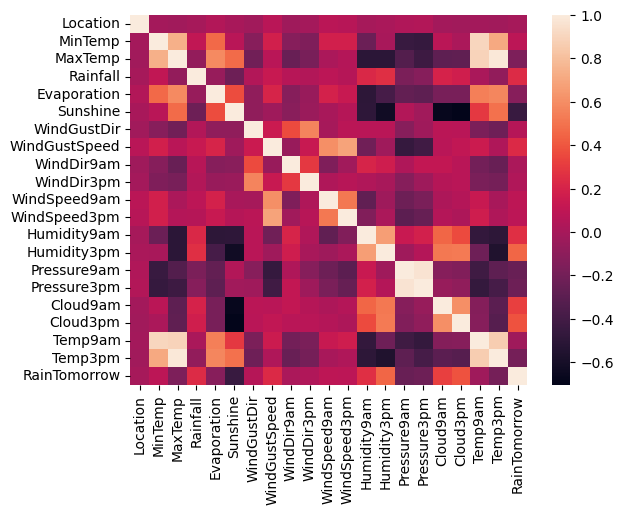

In [55]:
# 特征相关性

sns.heatmap(train.corr())

In [59]:
# 切分训练集和测试集
from sklearn.model_selection import train_test_split
# 假设 train 是已加载好的 DataFrame（比如从 CSV 等文件读取）

x = train.drop('RainTomorrow', axis=1)
y = train['RainTomorrow']

# 切分训练集和测试集
# 将训练集划分为训练集和验证集，便于后续模型评估
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2,   # 20% 作为验证集
    random_state=42, # 保证结果可复现
    stratify=y       # 分层采样，保持标签分布一致
)


In [60]:
# 构建模型
import xgboost as xgb
# 构建模型（以分类任务为例，若为回归任务用 XGBRegressor）
model = xgb.XGBClassifier(
    objective='binary:logistic',  # 二分类任务，目标函数设为 binary:logistic
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)
# 训练模型
model.fit(x_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [61]:
# 预测测试集并计算指标

# 预测
y_pred = model.predict(x_test)

# 计算准确率
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print("模型在测试集上的准确率：", acc)

模型在测试集上的准确率： 0.8522702298800052


### 模型调参

In [62]:
# 模型调参

param_grid = {
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [50, 100, 200],
    "gamma": [0, 0.1, 0.2, 0.5],
    "min_child_weight": [1, 3, 5]
}

# GridSearchCV


In [63]:
# 最佳参数和最高准确率
from sklearn.model_selection import GridSearchCV

# 使用GridSearchCV进行参数搜索
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)

print("最佳参数：", grid_search.best_params_)
print("最高准确率：", grid_search.best_score_)



Fitting 3 folds for each of 432 candidates, totalling 1296 fits
最佳参数： {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}
最高准确率： 0.8598837359571739


### 提交结果

In [64]:
# 计算结果集并保存
# 按照最佳参数设定模型，并对模型进行适配
best_params = grid_search.best_params_
model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    **best_params
)
model.fit(x_train, y_train)

result = model.predict(test)
# 保存预测结果并保存为文件，这里要注意因为测试集存在非法值，有一部分数据被删除，所以submit 中对应索引的行也要被删除
submit['RainTomorrow'] = result

# to_csv()